# 추가 필요 내용

# chapter 1. 통계적 사고와 기술통계

---

## 0.미리보는 함수

### 1. 데이터 탐색

| 함수 | 설명 | 예시 |
|------|------|------|
| `df.info()` | 데이터 타입, 결측치 확인 | `iris_df.info()` |
| `df.describe()` | 수치형 기술통계 요약 | `iris_df.describe()` |
| `df.describe(include='object')` | 범주형 기술통계 요약 | `iris_df.describe(include='object')` |
| `df['col'].value_counts()` | 범주별 빈도 | `df['species'].value_counts()` |
| `df['col'].value_counts(normalize=True)` | 범주별 비율 | `df['species'].value_counts(normalize=True)` |

### 2. 중심 지표 (대표값)

| 함수 | 설명 | 예시 |
|------|------|------|
| `df['col'].mean()` | 산술평균 | `df['petal_length'].mean()` |
| `df['col'].median()` | 중앙값 | `df['petal_length'].median()` |
| `df['col'].mode()` | 최빈값 | `df['petal_length'].mode()` |
| `stats.trim_mean(data, 비율)` | 절사평균 (scipy) | `stats.trim_mean(df['petal_length'], 0.1)` |
| `np.average(data, weights=가중치)` | 가중평균 (numpy) | `np.average(df['petal_length'], weights=df['weight'])` |


> **참고**: 절사평균과 가중평균은 pandas 기본 메소드가 없어서 scipy/numpy를 사용
> 
> ```python
> # 절사평균 - 직접 계산 (상하 10% 제거)
> sorted_data = df['petal_length'].sort_values()
> n = len(sorted_data)
> trim_n = int(n * 0.1)
> sorted_data.iloc[trim_n : n - trim_n].mean()
> 
> # 가중평균 - 직접 계산
> (df['value'] * df['weight']).sum() / df['weight'].sum()
> ```
> 
> groupby에서 사용하려면 `apply`나 `agg`에 lambda로 적용:
> ```python
> # 절사평균
> df.groupby('species')['petal_length'].apply(lambda x: stats.trim_mean(x, 0.1))
> 
> # 가중평균 (가중치 컬럼이 있을 때)
> df.groupby('species').apply(lambda g: np.average(g['petal_length'], weights=g['weight']))
> ```

### 3. 산포도

| 함수 | 설명 | 예시 |
|------|------|------|
| `df['col'].var()` | 표본분산 (n-1) | `df['petal_length'].var()` |
| `df['col'].var(ddof=0)` | 모분산 (n) | `df['petal_length'].var(ddof=0)` |
| `df['col'].std()` | 표본표준편차 | `df['petal_length'].std()` |
| `df['col'].std(ddof=0)` | 모표준편차 | `df['petal_length'].std(ddof=0)` |
| `df['col'].max() - df['col'].min()` | 범위 | `df['petal_length'].max() - df['petal_length'].min()` |
| `df['col'].quantile(q)` | 백분위수 | `df['petal_length'].quantile([0.25, 0.5, 0.75])` |
| `Q3 - Q1` | IQR | `df['petal_length'].quantile(0.75) - df['petal_length'].quantile(0.25)` |
| `df['col'].std() / df['col'].mean() * 100` | 변동계수 (CV, %) | `df['petal_length'].std() / df['petal_length'].mean() * 100` |

### 4. 그룹별 집계
```python
# 기본 집계
df.groupby('species')['petal_length'].mean()

# 다중 집계
df.groupby('species')['petal_length'].agg(['mean', 'median', 'std', 'min', 'max'])

# 커스텀 집계
df.groupby('species')['petal_length'].agg([
    ('평균', 'mean'),
    ('IQR', lambda x: x.quantile(0.75) - x.quantile(0.25))
])
```

### 5. 이상치 탐지
```python
# IQR 방법
Q1, Q3 = df['petal_length'].quantile(0.25), df['petal_length'].quantile(0.75)
IQR = Q3 - Q1
outliers = df['petal_length'][(df['petal_length'] < Q1 - 1.5*IQR) | (df['petal_length'] > Q3 + 1.5*IQR)]

# Z-score 방법
z_scores = (df['petal_length'] - df['petal_length'].mean()) / df['petal_length'].std()
outliers = df['petal_length'][np.abs(z_scores) > 2]  # 또는 > 3
```


#### IQR로 이상치 판별하는 법: IQR 분포 비대칭일때 쓰면 좋다.
> 데이터가 비대칭적인 분포일때는 IQR가 유리 (중앙값 기준)
- IQR = Q3 - Q1 # 가운데 50% 데이터 폭 → Q1 ~ Q3은 데이터가 가장 많이 몰린 구간
    - iqr_lower = Q1 - 1.5 * IQR # IQR을 바깥으로 조금 더 확장한다 → 정상 데이터 허용 범위를 살짝 늘림
    - iqr_upper = Q3 + 1.5 * IQR # IQR을 바깥으로 조금 더 확장한다 → 정상 데이터 허용 범위를 살짝 늘림
    - iqr_outliers = data[(data < iqr_lower) | (data > iqr_upper)] # 정상 데이터 범위 밖의 데이터를 이상치로 확정

#### Z-Score로 이상치 판별하는 법: z-score 분포가 정규분포 일때 쓰면 좋다.
> 대칭적 분포일 때는 z-score가 유리 (정규분포)
- Z = (값 - 평균) / 표준편차
- z_scores = (data - data.mean()) / data.std()
- z_outliers_2 = data[np.abs(z_scores) > 2] # 평균에서 표준편차 2개 이상 → 의심구간
- z_outliers_3 = data[np.abs(z_scores) > 3]  # 평균에서 표준편차 3개 이상 → 확정구간
    - np.abs(z_scores) 절대값 → 평균보다 매우 크거나 매우 작거나(음수)

### 6. 분포 형태

| 함수 | 설명 | 예시 |
|------|------|------|
| `df['col'].skew()` | 왜도 | `df['petal_length'].skew()` |
| `df['col'].kurtosis()` | 첨도 (초과첨도) | `df['petal_length'].kurtosis()` |

---

## 목차

| 순서 | 파트 | 주제 | 핵심 내용 |
|------|------|------|----------|
| 1 | Part 1 | 핵심 정리 | 기술/추론통계 비교, 데이터 유형, 측정 척도, 시각화 가이드 |
| 2 | Part 2 | 데이터 유형 탐색 | Iris·Wine 데이터로 수치형/범주형 구분, dtypes, describe(), value_counts() |
| 3 | Part 3 | 범주 데이터 | 최빈값, 막대도표, 파이차트 |
| 4 | Part 4 | 중심 지표 (대표값) | 산술평균, 절사평균, 가중평균, 중앙값, 최빈값 + 이상치 영향 비교 |
| 5 | Part 5 | 산포도 | 편차, 분산, 표준편차, 범위, IQR, 이상치 판별 + 베셀 보정(N-1) |
| 6 | Part 6 | 데이터 분포 탐색 | 박스플롯, 히스토그램, KDE, 바이올린 도표 (4가지 시각화) |
| 7 | Part 7 | 왜도와 첨도 | 왜도(비대칭), 첨도(꼬리 두께), 꼬리 리스크 개념 |

---

## Part 1. 통계적 사고 핵심 정리

### 기술통계 vs 추론통계
기술통계는 지금 가진 데이터를 요약하고,\
추론통계는 일부 데이터로 전체를 추정한다.

| 구분 | 기술통계 (Descriptive) | 추론통계 (Inferential) |
|------|----------------------|----------------------|
| **뭘 하는 가?** | 요약/시각화 | 예측 / 검정 |
| **보는 대상** | 현재의 데이터 | 모집단 |
| **쓰는 도구** | 평균, 중앙값, 그래프 등 | 가설검정, 신뢰구간, 회귀분석 등 |
| **예시** | "우리 반 시험 평균은 75점이야" | "이 약이 진짜 효과가 있을까?" |
| **확실한가?** | 확실함 (그냥 숫자 정리) | 불확실함 (확률로 판단) |

### 데이터의 유형
데이터가 숫자처럼 보여도, 척도에 따라 가능한 연산과 해석이 달라진다.


| 대분류                             | 소분류              | 핵심 정의                | 특징 키워드                 | 예시                 |
| ------------------------------- | ---------------- | -------------------- | ---------------------- | ------------------ |
| 수치형 <br>(Numerical / Quantitative)  | 이산형 (Discrete)   | **셀 수 있는 숫자 데이터**    | 정수 단위, 개수(count)       | 고객 수, 클릭 횟수, 결함 개수 |
| | 연속형 (Continuous) | **측정으로 얻는 숫자 데이터**   | 무한히 세분 가능, 측정(measure) | 키, 몸무게, 온도         |
| 범주형 <br>(Categorical / Qualitative) | 명목형 (Nominal)    | **구분만 의미 있고 순서 없음**  | 라벨(label), 순서 X        | 혈액형, 지역, 제품 카테고리   |
|  | 순서형 (Ordinal)    | **순서는 있지만 간격 의미 없음** | 순서 O, 간격 X             | 만족도 등급, 선호도 순위     |
|  | 이진형 (Binary)     | **두 가지 값만 갖는 범주형**   | 2개 범주, Yes/No          | 0/1, Yes/No        |


- 핵심정리
    - 수치형 데이터는 계산의 대상이다.
    - 범주형 데이터는 분류의 대상이다.
    - 데이터 유형에 따라 사용할 수 있는 통계 기법과 분석 방법이 달라진다.

### 2. 데이터 측정 척도
척도는 어떤 요약통계(평균/중앙값/빈도)와 어떤 비교(차이/비율)가 가능한지 정하는 규칙이다.

| 측정 척도 | 주로 해당하는 데이터 유형 | 순서 | 간격 동일 | 0=없음 | 쉬운 설명 | 예시 | 가능한 연산 |
|----------|----------------------|:----:|:--------:|:-----:|----------|------|-----------|
| **명목 척도** | 범주형 - 명목형 | X | X | X | 순서가 없고 이름만 구분 | 성별, 혈액형, 우편번호 | 빈도, 최빈값 |
| **순서 척도** | 범주형 - 순서형 | O | X | X | 순서는 있지만 간격 의미 없음 | 학점(A>B>C), 만족도(1~5), 등수 | + 중앙값, 순위비교 |
| **등간 척도** | 수치형 (특수한 경우) | O | O | X | 간격은 동일. 하지만 0이 "없음"이 아님 | 온도(0°C≠온도없음), IQ, 연도 | + 평균, 표준편차 |
| **비율 척도** | 수치형 (대부분의 수치 데이터) | O | O | O | 0이 진짜 "없음". 비율 계산 가능 | 키, 무게, 나이, 소득, 개수 | + 비율("2배") |

간단 요약
- 명목: 이름표(라벨)로만 구분되고 순서가 없는 척도
- 순서: 순서는 있지만, 값 사이 간격이 일정하다고 볼 수 없는 척도
- 등간: 간격은 동일하지만 0이 '없음'이 아니기에 비율(2배) 비교는 안 되는 척도
- 비율: 0이 '진짜 없음'을 뜻해, "2배/절반"과 같은 비율 비교가 가능한 척도

참고사항

등간 vs 비율은 0이 없음이냐로 구분한다.\
키 0cm = 키가 없음을 의미(비율)/0°C = 온도가 없는 게 아님(등간)

- 척도가 중요한 이유
  - 순서가 없으면 → 명목 척도: 평균 구하면 안 됨!
  - 순서만 있으면 → 순서 척도: 원칙적으로 평균 부적절 (간격이 동일하다는 보장 없음)
  - 0이 기준점이면 → 등간 척도: 평균 사용은 괜찮지만 2배란 표현은 부적절
    - 20°C가 10°C보다 2배 뜨거운 건 아님
  - 0이 "없음"이면 → 비율 척도: 모든 연산 가능
- 아래로 갈수록 더 많은 연산이 가능

미니 퀴즈 2문제(답은 바로 아래)

- 섭씨 온도는 평균을 내는 건 가능하지만 2배 뜨겁다는 조심해야 한다. 왜인가?
- 정답: 0°C가 없음이 아니라 기준점이라 비율 비교가 성립하지 않기 때문

- 직급(사원=1, 대리=2, 과장=3)처럼 숫자로 저장된 값은 보통 어떤 척도로 보는 게 안전한가?
- 정답: 순서 척도(순위는 있지만 간격 동일을 보장하기 어려움)

### 3. 데이터 유형별 시각화 가이드

#### 단변량 분석 (단일 변수 시각화)

| 데이터 유형 | 시각화 | 목적 | 용도 | 언제 쓰나? |
|------------|--------|------|------|-----------|
| **수치형 (연속)** | 히스토그램 | 분포 | 분포 형태 확인 (어디에 몰려 있나) | 데이터 분포를 처음 파악할 때 |
| | KDE (밀도그림) | 분포 | 부드러운 분포 곡선 | 여러 그룹의 분포를 겹쳐 비교할 때 |
| | 박스플롯 | 분포 | 5요약(Q1,중앙값,Q3,최소,최대) + 이상치 | 중심·퍼짐·이상치를 한눈에 파악할 때 |
| | 바이올린 도표 | 분포 | 분포 형태 + 요약 통계 | 박스플롯 + 밀도를 동시에 보고 싶을 때 |
| **수치형 (이산)** | 막대그래프 | 비교 | 각 정수 값의 빈도 | 값이 정수인 경우 (평점 1~5, 자녀 수 등) |
| **범주형 (명목)** | 막대그래프 | 비교 | 카테고리별 빈도 비교 | 남/여, 혈액형, 탑승항 등 그룹 크기 비교 |
| | 파이차트 | 구성 | 전체 대비 비율 강조 | 항목이 적고(5개 이하) 비율 강조할 때 |
| | 도넛 차트 | 구성 | 파이차트 변형, 중앙에 정보 표시 | 핵심 수치를 중앙에 강조할 때 |
| | 트리맵 | 구성 | 계층적 비율을 면적으로 표현 | 항목이 많거나 계층 구조가 있을 때 |
| | 와플 차트 | 구성 | 비율을 격자로 직관 표현 | 파이차트 대안, 퍼센트 강조할 때 |
| **범주형 (순서)** | 막대그래프 (순서 유지) | 비교 | 순서 + 빈도 확인 | 학점, 만족도, 등급 등 순서가 있는 범주 |

#### 이변량 분석 (두 변수 조합 시각화)

| 데이터 조합 | 시각화 | 목적 | 용도 | 언제 쓰나? |
|------------|--------|------|------|-----------|
| **수치 × 수치** | 산점도 (Scatter) | 관계 | 두 변수의 관계 확인 | 상관관계, 군집, 이상치 패턴 확인 |
| | 히트맵 (상관행렬) | 관계 | 여러 변수 상관관계 한눈에 | 변수가 많을 때 전체 관계를 색깔로 파악 |
| **수치 × 범주** | 그룹별 박스플롯 | 비교/분포 | 그룹 간 분포 비교 | 남녀별 키, 등급별1 요금 등 |
| | 그룹별 바이올린 | 비교/분포 | 그룹 간 분포 + 형태 비교 | 분포 형태까지 세밀하게 비교할 때 |
| | 그룹별 히스토그램 | 비교/분포 | 그룹 분포 겹쳐 비교 | 분포의 겹침/분리 정도 확인 |
| **시간 × 수치** | 선 그래프 (Line) | 비교 | 시간에 따른 변화 추세 | 매출 추이, 기온 변화, 주가 등 |
| | 영역 그래프 (Area) | 비교/구성 | 추세 + 누적 크기 강조 | 카테고리별 매출 누적 추이 |
| | 다중 축 차트 (Multi-Axis) | 비교 | 스케일이 다른 변수를 겹쳐 비교 | 매출(억) vs 고객수(명) 동시 비교 |
| **범주 × 범주** | 누적 막대그래프 | 구성 | 교차 빈도/비율 | 성별×생존, 등급×탑승항 등 |
| | 모자이크 플롯 | 구성 | 교차 비율 (면적) | 두 범주 변수의 관계를 면적으로 표현 |

### 4. 기술통계 핵심 요약

| 분류 | 통계량 | 쉬운 설명 | 이상치에 흔들리나? |
|------|--------|----------|:----------------:|
| **중심 지표** | 평균 (Mean) | 전부 더해서 개수로 나누기 | 많이 흔들림 |
| *(대표 선수)* | 중앙값 (Median) | 줄 세운 다음 한가운데 값 | 거의 안 흔들림 |
| | 절사평균 (Trimmed Mean) | 양쪽 극단값 빼고 평균 | 조금 흔들림 |
| | 가중평균 | 가중치로 평균을 내기 | 많이 흔들림 |
| **산포도** | 분산 (Variance) | 평균에서 얼마나 떨어져 있나 (제곱) | 많이 흔들림 |
| *(얼마나 퍼져 있나)* | 표준편차 (Std Dev) | 분산에 루트 씌운 것 (원래 단위) | 많이 흔들림 |
| | IQR | 상위 25% 값 - 하위 25% 값 | 거의 안 흔들림 |
| | 변동계수 (CV) | 표준편차 ÷ 평균 (상대적 퍼짐, %) | 많이 흔들림 |
| **분포 모양** | 왜도 (Skewness) | 좌우 대칭인가, 한쪽으로 치우쳤나 | - |
| | 첨도 (Kurtosis) | 꼬리가 두꺼운가, 얇은가 (극단값 빈도) | - |

In [1]:
# 필수 라이브러리 Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_iris, load_wine
import warnings
import platform

warnings.filterwarnings('ignore')

# 운영체제별 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

print("="*60)
print("1회차 실습 과제: 통계적 사고와 기술통계")
print("="*60)

1회차 실습 과제: 통계적 사고와 기술통계


---

## Part 2: 데이터 유형 탐색

목표
1. 수치형으로 요약할 컬럼이 뭔지
2. 범주형으로 요약할 컬럼이 뭔지
3. 결측치/형태가 이상한 컬럼이 있는지

를 빠르게 결정하는 단계다.

### sklearn 데이터셋으로 수치형/범주형 데이터 구분해보기

항상 데이터 분석의 첫단추는 **가지고 있는 데이터의 타입 파악**이다.

- **수치형**: 숫자로 되어 있고 계산할 수 있는 데이터 (키, 몸무게, 점수)
- **범주형**: 그룹/카테고리를 나타내는 데이터 (성별, 혈액형, 품종)

해야하는것.

1. 데이터 로드(데이터프레임 구성, 타깃 컬럼 추가, 코드→이름 매핑)
2. info로 먼저 구조 확인(행/열, dtype, 결측치)
3. head로 샘플 확인(값이 측정값인지 코드인지)
4. describe로 수치형 요약(평균/표준편차/사분위)
5. describe + value_counts로 범주형 요약(종류 수, 최빈, 비율)
6. 최종 결론: 수치형 컬럼 목록 / 범주형 컬럼 목록(의미 기준)

- info(): 컬럼별 dtype과 결측치(Non-Null Count)를 한 번에 확인한다
- head(): 실제 값 형태 확인한다 (10개)
- describe(include=['int','float']): 수치형 컬럼의 중심/퍼짐/분포 위치를 요약한다.
    - count: 결측 제외한 개수
    - mean: 평균
    - std: 표준편차
    - min, 25%, 50%(중앙값), 75%, max: 분포의 위치
- describe(include=['object','category']): 범주형 컬럼의 구성(몇 종류인지, 뭐가 가장 흔한지)을 요약한다.
    - count: 값 개수
    - unique: 범주 종류 개수
    - top: 가장 많이 나온 범주(최빈)
    - freq: top의 빈도
- value_counts(): 범주형의 분포를 개수와 비율로 측정한다.
    - normalize=True: 전체 대비 비율(합이 1)


#### 붓꽃 데이터

In [3]:
print("\n" + "="*60)
print("Part 2: 데이터 유형 탐색")
print("="*60)

# (1) Iris(붓꽃) 데이터 로드
# - 붓꽃 150송이의 꽃잎/꽃받침 크기를 측정한 유명한 데이터
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
# iris.target: 각 행(꽃 1송이)이 어떤 품종인지 나타내는 "정답 라벨" (0/1/2로 저장됨)
# species 컬럼을 새로 만들고, 그 안에 iris.target을 통해 만든 라벨을 삽입
iris_df['species'] = iris.target 

# species_name 컬럼 생성
iris_df['species_name'] = (
    iris_df['species']  # iris_df의 species컬럼을 변환
    .map({              # map: "값을 다른 값으로 치환"하는 함수
        0: 'setosa',        # species가 0이면 setosa로 바꿈
        1: 'versicolor',    # species가 1이면 versicolor로 바꿈
        2: 'virginica'      # species가 2이면 virginica로 바꿈
}))

# (2) 데이터 칼럼 및 타입 확인
print("\n" + "="*60)
print("info로 데이터 타입 파악")
iris_df.info() # 이산형, 범주형 구분
display(iris_df.head()) # 샘플 데이터 확인


# (3) 이산형 데이터의 기술 통계를 한눈에 파악하기 위한 함수 (.describe[이산형])
# display(iris_df.describe()) 도 가능
print("\n" + "="*60)
print("describe로 수치형 컬럼 요약")
display(iris_df
        .describe(include=['int', 'float']) 
        .round(2))

# (4) 범주형의 기술 통계를 한눈에 파악하기 위한 함수 (.describe[범주형])
print("\n" + "="*60)
print("describe로 범주형 컬럼 요약")
display(iris_df
        .describe(include=['object', 'category'])
        .round(2))

# (5) 범주형 데이터 빈도 파악 (.value_counts)
print("\n" + "="*60)
print("범주형 데이터 빈도 파악")
display(iris_df['species_name']
        .value_counts())
print("\n범주의 비율")
display(iris_df['species_name']
        .value_counts(normalize=True)
        .round(2)) # 범주의 비율



Part 2: 데이터 유형 탐색

info로 데이터 타입 파악
<class 'pandas.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
 5   species_name       150 non-null    str    
dtypes: float64(4), int64(1), str(1)
memory usage: 7.2 KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa



describe로 수치형 컬럼 요약


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.00,150.00,150.00,150.00,150.00
mean,5.84,3.06,3.76,1.20,1.00
std,0.83,0.44,1.77,0.76,0.82
min,4.30,2.00,1.00,0.10,0.00
25%,5.10,2.80,1.60,0.30,0.00
50%,5.80,3.00,4.35,1.30,1.00
75%,6.40,3.30,5.10,1.80,2.00
max,7.90,4.40,6.90,2.50,2.00



describe로 범주형 컬럼 요약


,species_name
count,150
unique,3
top,setosa
freq,50



범주형 데이터 빈도 파악


species_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


범주의 비율


species_name
setosa        0.33
versicolor    0.33
virginica     0.33
Name: proportion, dtype: float64

#### 와인 데이터

In [5]:
print("\n" + "="*60)
print("Wine 데이터 유형 탐색")
print("="*60)

# (1) Wine(와인) 데이터 로드
# - 이탈리아 3개 지역 와인 178개의 화학 성분을 분석한 데이터
wine = load_wine()
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_df['class'] = wine.target
wine_df['class_name'] = (wine_df['class']
    .map({
        0: 'class_0', 
        1: 'class_1', 
        2: 'class_2'
}))

# (3) 수치형 데이터의 기술 통계를 한눈에 파악하기 위한 함수
display(wine_df.describe().round(2))

# (4) 범주형의 기술 통계를 한눈에 파악하기 위한 함수
display(wine_df
        .describe(include=['object', 'category'])
        .round(2))

# (5) 범주형 데이터 빈도 확인
display(wine_df['class_name']
        .value_counts())

display(wine_df['class_name']
        .value_counts(normalize=True)
        .round(2)) # 범주의 비율


Wine 데이터 유형 탐색


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89,0.94
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91,0.78
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00,0.00
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.20,0.27,1.25,3.22,0.78,1.94,500.50,0.00
50%,13.05,1.87,2.36,19.50,98.00,2.36,2.13,0.34,1.56,4.69,0.96,2.78,673.50,1.00
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00,2.00
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00,2.00


,class_name
count,178
unique,3
top,class_1
freq,71


class_name
class_1    71
class_0    59
class_2    48
Name: count, dtype: int64

class_name
class_1    0.40
class_0    0.33
class_2    0.27
Name: proportion, dtype: float64

---

## Part 3: 기술통계 - 범주 데이터

### 범주형 데이터 → 빈도 세기, 막대/파이차트

| 시각화 | 용도 | 언제 쓰나? |
|--------|------|-----------|
| 막대그래프 | 카테고리별 빈도/크기 비교 | 항목 간 크기를 직접 비교할 때 |
| 파이차트 | 전체 대비 비율 강조 | 항목이 적고(5개 이하) 비율을 강조할 때 |

- 선택 기준
    - 비교가 목적이면 **막대그래프**
    - 비율 강조가 목적이면 **파이차트**

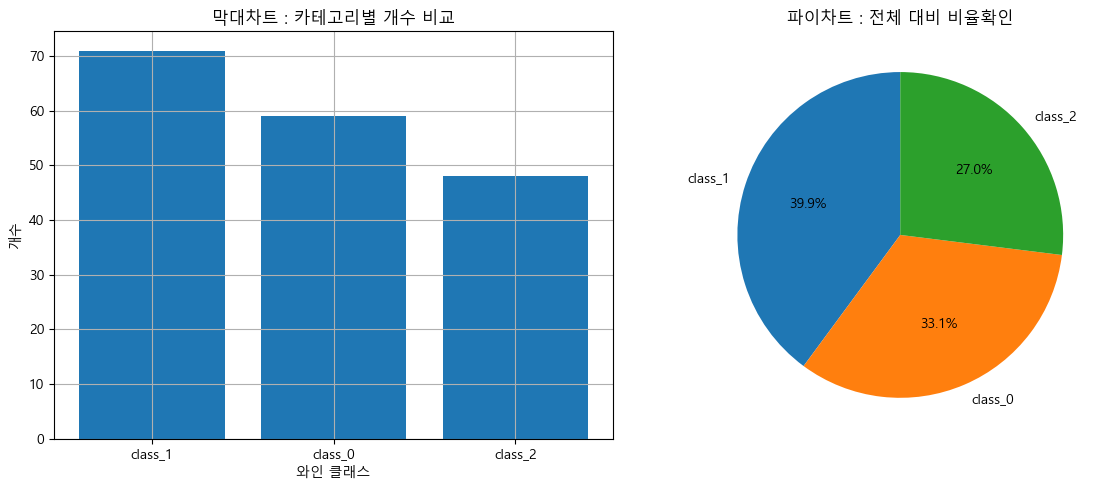

In [6]:
# 범주 데이터 시각화: 막대도표 & 파이차트
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) #1행, 2열 (1X2 그래프 그림)

# 데이터를 준비
class_counts = wine_df['class_name'].value_counts()

# 막대 차트 (1행 1열)
ax[0].bar(class_counts.index, class_counts.values)
ax[0].set_xlabel('와인 클래스')
ax[0].set_ylabel('개수')
ax[0].set_title("막대차트 : 카테고리별 개수 비교")
ax[0].grid(True)


# 파이 차트 (1행 2열)
ax[1].pie(class_counts.values, labels=class_counts.index, autopct='%.1f%%', startangle=90)
ax[1].set_title("파이차트 : 전체 대비 비율확인")

plt.tight_layout()
plt.show()

---

## Part 4: 기술통계 - 중심 지표 (대표값)

### "이 데이터를 숫자 하나로 요약하면?" → 평균, 중앙값, 최빈값, 절사평균, 가중평균
데이터를 대표하는 값을 구하는 방법은 여러 가지로 각각 장단점이 존재하기에 상황에 맞게 골라 써야 한다.

#### 대표값 비교
| 대표값                 | 한 줄 정리             | 계산방법(감만)           | 장단점(핵심만)                                               | 사용 코드(함수)                             |
| ------------------- | ------------------ | ------------------ | ------------------------------------------------------ | ------------------------------------- |
| 산술평균(mean)          | 전부 평균내서 전체 중심을 잡는다 | 합 ÷ 개수             | 장점: 직관적, 많이 씀 / 단점: 이상치에 매우 민감, 다봉/치우침에서 대표성이 약함       | `s.mean()` (pandas), `np.mean(x)`     |
| 중앙값(median)         | 정렬했을 때 가운데 값이다     | 정렬 → 가운데           | 장점: 이상치/치우침에 강함 / 단점: 모든 값을 “고르게 반영”하진 않음              | `s.median()` (pandas), `np.median(x)` |
| 최빈값(mode)           | 가장 자주 나온 값이다       | 빈도 세서 최대           | 장점: 범주형 대표값으로 좋음 / 단점: 수치형 연속 데이터에선 의미 약해지기 쉬움(동률도 흔함) | `s.mode()` (pandas)                   |
| 절사평균(trimmed mean)  | 극단값 일부를 버리고 평균낸다   | 정렬 → 양쪽 p% 제거 → 평균 | 장점: 평균의 장점 유지 + 이상치 영향 감소 / 단점: 절사 비율 선택이 필요           | `stats.trim_mean(x, p)` (scipy)       |
| 가중평균(weighted mean) | 중요도(비중)를 반영한 평균이다  | 값×가중치 합 ÷ 가중치 합    | 장점: 비중을 반영한 대표값 가능 / 단점: 가중치 설정이 필요(주관/정의 문제)          | `np.average(x, weights=w)`            |

- 이상치/치우침이 의심되면: 평균 단독 금지, 중앙값 또는 절사평균을 같이 본다
- 여러 집단이 섞인 데이터(다봉 가능)면: 전체 대표값보다 그룹별 대표값을 본다
- 비중이 존재하면: 가중평균을 쓴다

미니 퀴즈 2문제(답은 바로 아래)
- 소득/연봉처럼 이상치가 큰 데이터에서 대표값으로 평균만 쓰기 위험한 이유는?\
정답: 극단값 1~몇 개가 평균을 크게 끌어올려 "대부분"을 대표하지 못할 수 있기 때문

- 항목별 중요도(학점, 포트폴리오 비중)가 주어졌을 때 자연스러운 대표값은?\
정답: 가중평균

### ⚠️ 평균의 함정: 평균만 믿지 마라!
평균은 가장 흔히 쓰이는 대표값이지만, **단독으로 쓰면 위험한 경우**가 많다.

1. 이상치의 영향 <br>
평균 → 실제보다 과대<br>
중앙값 → 현실에 가까움<br>
직원 9명 연봉: 3000 ~ 4000<br>
사장 1명: 5억<br>

2. 분포의 형태 숨김 <br>
평균은 동일하지만 실제 분포는 완전히 다름 <br>
A반 = 70 ~ 74 → 고르게 분포<br>
B반 = 40 ~ 108 → 편차 큼<br>
해결: 시각화를 통해 데이터 분포를 확인

3. 다봉(두 봉우리) 분포 문제 <br>
남녀 키 혼합 데이터 남녀 키 혼합 데이터 <br>
전체 평균 → 실제 대표값 의미 없음 <br>
해결: 그룹을 나눠 분석

#### 실전 원칙
1. **히스토그램을 먼저 그려라** → 분포 형태, 이상치, 봉우리 개수 확인
2. **이상치가 있거나 분포가 치우쳐 있으면** → 중앙값(Median)을 함께 제시
    - **평균과 중앙값의 차이가 크면** → 비대칭이 크다는 신호
3. **봉우리가 2개 이상이면(다봉 분포)** → 평균·중앙값 모두 무의미! 그룹을 나눠서 각각 분석

In [ ]:
# Iris 꽃잎 길이 데이터 사용
petal_length = iris_df['petal length (cm)']
display(petal_length.head(10))

# (1) 산술평균: .mean()
print(f"산술평균:{petal_length.mean():.2f}")

# (2) 절사평균 - 극단값을 잘라낸 평균
# stats.trim_mean(평균 구할거, 상하위 몇 퍼 자를꺼야)
print(f"절사평균(10%):{stats.trim_mean(petal_length, 0.1):.2f}") # 상하위 10% 제거후 평균
# print(f"절사평균:{stats.trim_mean(petal_length, 0.2):.2f}") # 상하위 20% 제거후 평균

# (3) 가중평균 - 중요도에 따라 가중치를 다르게 주는 평균
# 각 붓꽃 종별로 가중평균을 구하라
species_mean = (
        iris_df
        .groupby('species_name')['petal length (cm)'] # species_name 기준으로 묶는다
        .mean())        # 그룹별 평균 계산
print("\n" + "="*60)
print("붓꽃 그룹별 평균 계산")
display(species_mean.round(2))
print("="*60)
# setosa        1.46
# versicolor    4.26
# virginica     5.55
# (1.46*50 + 4.26*30 + 5.55*20) / (50+30+20)
weights = np.array([50, 30, 20]) # 클래스 별 가중치
weighted_mean = np.average(species_mean, weights=weights)


print(f'가중평균: {weighted_mean:.2f}')

# (4) 중앙값 - 줄 세우고 한가운데 값
# .median()  중앙값
print(f'중앙값: {petal_length.median():.2f}')

# (5) 최빈값 - 가장 많이 나타나는 값
print(f'최빈값: {petal_length.mode().values}')

0    1.4
1    1.4
2    1.3
3    1.5
4    1.4
5    1.7
6    1.4
7    1.5
8    1.4
9    1.5
Name: petal length (cm), dtype: float64

산술평균:3.76
절사평균(10%):3.76

붓꽃 그룹별 평균 계산


species_name
setosa        1.46
versicolor    4.26
virginica     5.55
Name: petal length (cm), dtype: float64

가중평균: 3.12
중앙값: 4.35
최빈값: [1.4 1.5]


### ⚠️이상치가 평균/중앙값에 미치는 영향 비교⚠️

In [ ]:
# 직원 9명 연봉 (단위: 만원)
employees = pd.Series([3000, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 4000])

# 사장 포함 (5억 = 50000만원)
with_ceo = pd.concat([employees, pd.Series([50000])], ignore_index=True)

comparison = pd.DataFrame({
    '통계량': ['산술평균', '절사평균(10%)', '중앙값'],
    '직원만 (9명)': [employees.mean(), stats.trim_mean(employees, 0.1), employees.median()],
    '사장 포함(10명)': [with_ceo.mean(), stats.trim_mean(with_ceo, 0.1), with_ceo.median()],
})
display(comparison)

,통계량,직원만 (9명),사장 포함(10명)
0,산술평균,3500.0,8150.0
1,절사평균(10%),3500.0,3562.5
2,중앙값,3500.0,3550.0


,통계량,값,구분
0,산술평균,3500.0,직원만
1,절사평균(10%),3500.0,직원만
2,중앙값,3500.0,직원만
3,산술평균,8150.0,사장 포함
4,절사평균(10%),3562.5,사장 포함
5,중앙값,3550.0,사장 포함


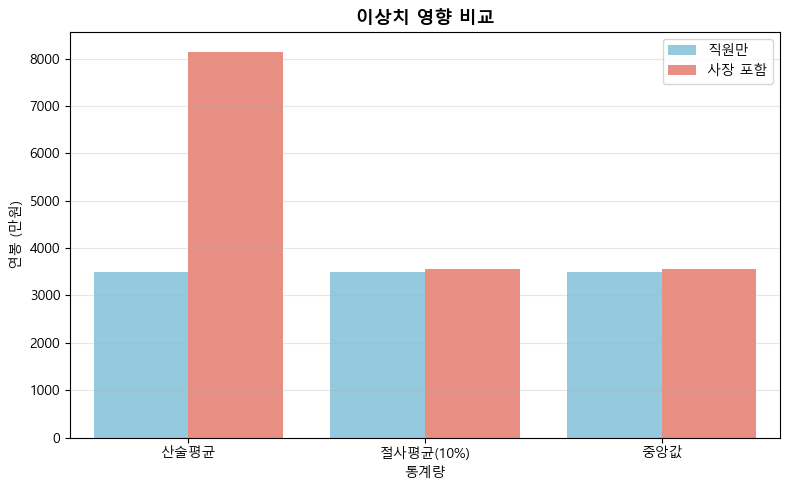

In [ ]:
# 비교 막대그래프
fig, ax = plt.subplots(figsize=(8, 5))

compare_df = pd.DataFrame({
    '통계량': ['산술평균', '절사평균(10%)', '중앙값'] * 2,
    '값': [employees.mean(), stats.trim_mean(employees, 0.10), employees.median(),
            with_ceo.mean(), stats.trim_mean(with_ceo, 0.10), with_ceo.median()],
    '구분': ['직원만'] * 3 + ['사장 포함'] * 3
})
display(compare_df) #값 확인

sns.barplot(data=compare_df, x='통계량', y='값', hue='구분', palette=['skyblue', 'salmon'], ax=ax)
ax.set_title('이상치 영향 비교', fontsize=13, fontweight='bold')
ax.set_ylabel('연봉 (만원)')
ax.legend(title='')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---

## Part 5: 기술통계 - 산포도 (데이터가 얼마나 퍼져 있나?)
대표값이 “중심”이라면, 산포도는 “얼마나 흩어져 있나”를 숫자로 요약하는 단계다.
평균이 같아도 산포가 다르면 데이터 성격이 완전히 달라질 수 있다.

위에서 다룬 이상치가 평균에 미치는 영향과 같이, 평균이 같더라도 데이터는 다를수 있다.\
**산포도는** 데이터가 평균 주변에 얼마나 퍼져 있는지를 보여준다.

예를 들어, 시험 평균이 둘 다 70점이라도
- A반: 65 ~ 75 → 값이 비슷 → (산포 작음)  → **모여 있음**
- B반: 30 ~ 100 → 값 다양 → (산포 큼)  → **흩어져 있음**

평균만 본다면 A와 B는 같지만, 산포도를 확인하면 전혀 다른 개념이다.

![같은 평균 다른 표준편차](images/pr_01/same_mean_other_std.png)

#### 산포도 지표 비교
| 지표        | 의미          | 기준  | 이상치 영향 |
| --------- | ----------- | --- | ------ |
| 분산 / 표준편차 | 평균 기준 퍼짐 정도 | 평균  | 큼      |
| IQR       | 중간 50% 퍼짐   | 중앙값 | 작음     |
| 범위        | 전체 폭        | 없음  | 매우 큼   |

- 핵심 감각 정리
    - 표준편차(분산) 크다 → 데이터 들쭉날쭉
    - IQR 작다 → 데이터 가운데 몰림
    - 범위 크다 → 극단값 있을 가능성

- 핵심정리
    - 산포 = 데이터 퍼짐 정도
    - 기본 = 표준편차
    - 이상치 많음 = IQR
    - 이상치 탐지 = IQR 먼저
    - 범위 = 참고용

| 지표             | 한 줄 정리                     | 계산방법(감만)                       | 장단점(핵심만)                                               | 사용 코드(함수)                                                    |             
| -------------- | -------------------------- | ------------------------------ | ------------------------------------------------------ | ------------------------------------------------------------ |
| 편차(deviation)  | 각 값이 평균에서 얼마나 떨어졌는지        | xi − mean                      | 장점: 방향(±)까지 보임<br>단점: 합치면 상쇄돼 산포 요약엔 직접 못 씀             | `x - x.mean()` (pandas), `x - np.mean(x)`                    |             
| 분산(variance)   | 평균 기준 퍼짐을 제곱으로 누적한 값       | 평균((xi−mean)^2)                | 장점: 표준편차의 기반<br>단점: 단위가 제곱이라 직관 떨어짐, 이상치에 민감            | `x.var(ddof=1)` (pandas), `np.var(x, ddof=1)`                |             
| 표준편차(std)      | 평균에서 보통 이 정도 벗어난다(원 단위 유지) | sqrt(분산)                       | 장점: 해석 쉬움, 기본 산포 지표<br>단점: 이상치에 민감                      | `x.std(ddof=1)` (pandas), `np.std(x, ddof=1)`                |             
| 범위(range)      | 전체 폭(최대−최소)                | max − min                      | 장점: 계산 매우 단순<br>단점: 이상치 1개에 크게 흔들림(참고용)                 | `x.max() - x.min()` (pandas), `np.ptp(x)`                    |             
| 사분위수(Q1,Q2,Q3) | 분포 위치를 25/50/75%로 요약       | quantile(0.25/0.5/0.75)        | 장점: 분포 위치를 견고하게 요약<br>단점: “퍼짐 1개 숫자”가 아니라 위치 지표         | `x.quantile(0.25)`, `x.quantile(0.5)`, `x.quantile(0.75)`    |             
| IQR            | 가운데 50%의 퍼짐                | Q3 − Q1                        | 장점: 이상치에 강함, 분포가 치우쳐도 안정적<br>단점: 꼬리(극단값)의 퍼짐은 직접 반영 안 됨 | `x.quantile(0.75) - x.quantile(0.25)`                        |             
| IQR 이상치 기준     | IQR로 이상치 후보를 잡는다           | x < Q1−1.5IQR or x > Q3+1.5IQR | 장점: 가정(정규성) 약함, 실무에서 자주 씀<br>단점: “후보”일 뿐이라 삭제는 별도 판단 필요 | `lower = Q1 - 1.5*IQR`, `upper = Q3 + 1.5*IQR`, `x[(x<lower) and (x>upper)]` |


#### 이상치 탐지 방법
이상치 탐지는 제거가 아니라 ‘후보를 표시’하는 단계이며, 분포/가정에 따라 IQR 또는 Z-score를 쓴다.

**1. IQR 방법**: $\quad x < Q_1 - 1.5 \cdot IQR \quad \text{or} \quad x > Q_3 + 1.5 \cdot IQR$\
중앙 50% 기준으로 허용 경계를 만들고 밖을 이상치 후보로 본다.\
데이터가 비대칭적인 분포일때 사용

**2. Z-score 방법**: $\quad |z| = \left|\frac{x - \bar{x}}{s}\right| > k \quad (k = 2 \sim 3)$\
평균과 표준편차 기준으로 표준화해서 평균에서 멀리 떨어진 값을 후보로 본다.\
데이터가 대칭적 분포(정규분포)일 때 사용

<img src="images/pr_01/normal_dist.png" width="50%">

IQR 방식
```
이상치 기준
Q1 - 1.5 × IQR ~ Q3 + 1.5 × IQR를 정상치 기준
이 밖에 있는 값들을 이상치로 판단
```
IQR은 Q1~Q3 사이의 중앙 데이터 범위이고,\
Q1 - 1.5×IQR 과 Q3 + 1.5×IQR 은 정상 데이터의 허용 경계를 의미한다.\
이 범위를 벗어나면 이상치로 판단한다.


Z-score 방식
```
이상치 기준
Z = (값 - 평균) / 표준편차
```
|Z| > 2 → 의심<br>
|Z| > 3 → 이상치<br>

공통해석: 기준을 넘었다 = **이상치 확정**이 아니라 **값을 확인할 필요가 있는 후보**다.


실생활 예시: 같은 평균 수익률, 다른 리스크
두 투자 상품의 평균 수익률이 모두 8%라면, 어떤 걸 고르겠습니까?


,구분,평균 수익률(%),표준편차(%),최악의 수익률,최고의 수익률
0,상품A,7.99,3.01,-3.77,19.78
1,상품B,8.14,10.01,-30.56,52.79


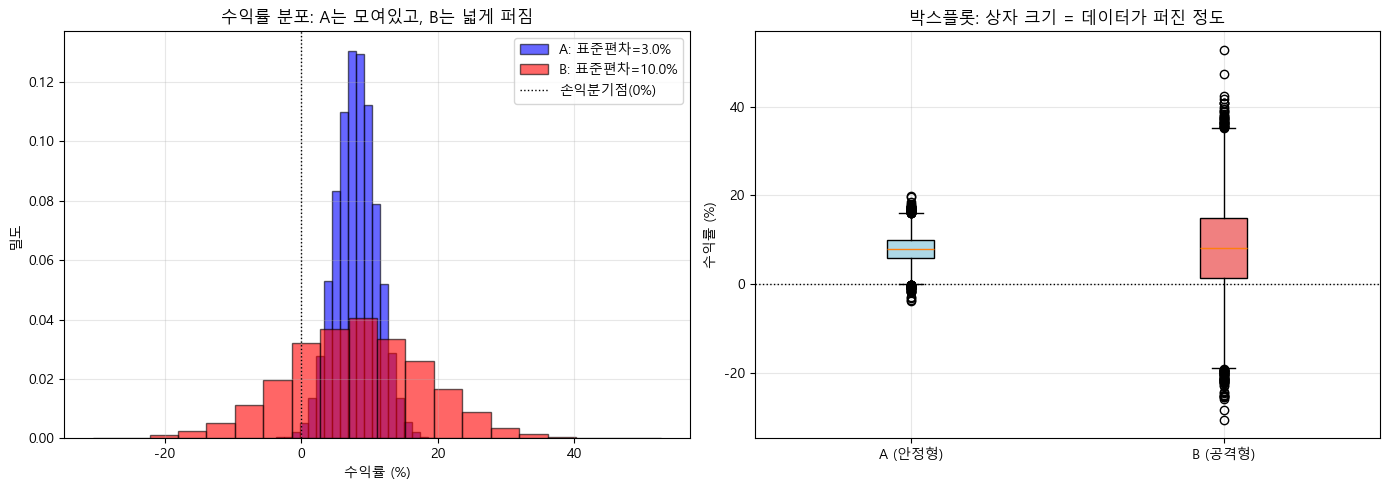

In [ ]:
# 실생활 예시: 같은 수익률, 다른 리스크
print("\n" + "="*60)
print("실생활 예시: 같은 평균 수익률, 다른 리스크")
print("="*60)
print("두 투자 상품의 평균 수익률이 모두 8%라면, 어떤 걸 고르겠습니까?")

# 두 투자 상품 시뮬레이션
investment_A = np.random.normal(8, 3, 10000) #평균 8, 표준편차 3, 데이터 개수 10000개의 데이터를 정규분포에서 샘플링
investment_B = np.random.normal(8, 10, 10000) #평균 8, 표준편차 10, 데이터 개수 10000개의 데이터를 정규분포에서 샘플링

invest_df = pd.DataFrame({
    '구분': ['상품A', '상품B'],
    '평균 수익률(%)' : [investment_A.mean(), investment_B.mean()],
    '표준편차(%)' : [investment_A.std(), investment_B.std()],
    '최악의 수익률' : [investment_A.min(), investment_B.min()],
    '최고의 수익률' : [investment_A.max(), investment_B.max()],
})
display(invest_df.round(2))

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
ax[0].hist(investment_A, bins=20, alpha=0.6, color='blue', edgecolor='black',
             label=f'A: 표준편차={investment_A.std():.1f}%', density=True)
ax[0].hist(investment_B, bins=20, alpha=0.6, color='red', edgecolor='black',
             label=f'B: 표준편차={investment_B.std():.1f}%', density=True)
ax[0].axvline(0, color='black', linestyle=':', linewidth=1, label='손익분기점(0%)')
ax[0].set_xlabel('수익률 (%)')
ax[0].set_ylabel('밀도')
ax[0].set_title('수익률 분포: A는 모여있고, B는 넓게 퍼짐')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 박스플롯
bp = ax[1].boxplot([investment_A, investment_B],
                     labels=['A (안정형)', 'B (공격형)'],
                     patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax[1].axhline(0, color='black', linestyle=':', linewidth=1)
ax[1].set_ylabel('수익률 (%)')
ax[1].set_title('박스플롯: 상자 크기 = 데이터가 퍼진 정도')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*60)
print("Part 5: 기술통계 - 산포도")
print("="*60)

# Wine 알코올 도수 사용
data = wine_df['alcohol']
display(data.head())

# (1) 편차 - 각 값이 평균에서 얼마나 떨어져 있는가
deviations = data - data.mean()
print("편차 : ")
display(deviations.head())

# (2) 분산 - 편차 제곱의 평균
# 데이터의 개수가 많으면 모집단과 표본집단의 값은 비슷해진다.
print(f"분산 (모집단) : {data.var(ddof=0):.4f}")
print(f"분산 (표본집단): {data.var(ddof=1):.4f}") 

# (3) 표준편차 - 분산에 루트를 씌워서 원래 단위로 되돌림
print(f"표준편차 (모집단) : {data.std(ddof=0):.4f}")
print(f"표준편차 (표본집단): {data.std(ddof=1):.4f}") 

# (4) 범위 - 가장 단순한 산포 지표
print(f"범위(max-min): {data.max() - data.min():.4f}") 


# (5) 백분위수와 IQR
Q1 = data.quantile(0.25) 
Q2 = data.quantile(0.5) 
Q3 = data.quantile(0.75) 
print(f"Q1: {Q1}") 
print(f"Q2: {Q2}") 
print(f"Q3: {Q3}") 
print(f"IQR: {Q3 - Q1:.4f}") # Q3~Q1 범위

# (6) 이상치 판별
# 6-1) IQR 기반 이상치 판별 방법
IQR = Q3 - Q1
iqr_lower = Q1 - 1.5 * IQR
iqr_upper = Q3 + 1.5 * IQR
iqr_outliers = data[(data < iqr_lower) | (data > iqr_upper)]
print('IQR 이상치:')
print('IQR 이상치 개수:', len(iqr_outliers))
display(iqr_outliers.head())

# 6-2) Z-Score 방법
z_scores = (data - data.mean()) / data.std() # Z = (값 - 평균) / 표준편차
z_outliers_2 = data[np.abs(z_scores) > 2] # abs 절대값
z_outliers_3 = data[np.abs(z_scores) > 3]
print('Z-score 이상치:')
print('|Z-score| > 2 이상치 개수:', len(z_outliers_2))
print('|Z-score| > 3 이상치 개수:', len(z_outliers_3))


# (7) 클래스별 알콜 산포도 비교
class_stats = wine_df.groupby('class_name')['alcohol'].agg([
    ('평균', 'mean'),
    ('분산', 'var'),
    ('표준편차', 'std'),
    ('최소', 'min'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q2', lambda x: x.quantile(0.5)),
    ('Q3', lambda x: x.quantile(0.75)),
    ('최대', 'max'),
    ('범위', lambda x: x.max() - x.min()),
    ('IQR', lambda x: x.quantile(0.75) - x.quantile(0.25)),
])
display(class_stats)


Part 5: 기술통계 - 산포도


0    14.23
1    13.20
2    13.16
3    14.37
4    13.24
Name: alcohol, dtype: float64

편차 : 


0    1.229382
1    0.199382
2    0.159382
3    1.369382
4    0.239382
Name: alcohol, dtype: float64

분산 (모집단) : 0.6554
분산 (표본집단): 0.6591
표준편차 (모집단) : 0.8095
표준편차 (표본집단): 0.8118
범위(max-min): 3.8000
Q1: 12.362499999999999
Q2: 13.05
Q3: 13.6775
IQR: 1.3150
IQR 이상치:
IQR 이상치 개수: 0


Series([], Name: alcohol, dtype: float64)

Z-score 이상치:
|Z-score| > 2 이상치 개수: 3
|Z-score| > 3 이상치 개수: 0


,평균,분산,표준편차,최소,Q1,Q2,Q3,최대,범위,IQR
class_name,,,,,,,,,,
class_0,13.744746,0.213560,0.462125,12.85,13.400,13.750,14.100,14.83,1.98,0.7
class_1,12.278732,0.289406,0.537964,11.03,11.915,12.290,12.515,13.86,2.83,0.6
class_2,13.153750,0.281156,0.530241,12.20,12.805,13.165,13.505,14.34,2.14,0.7


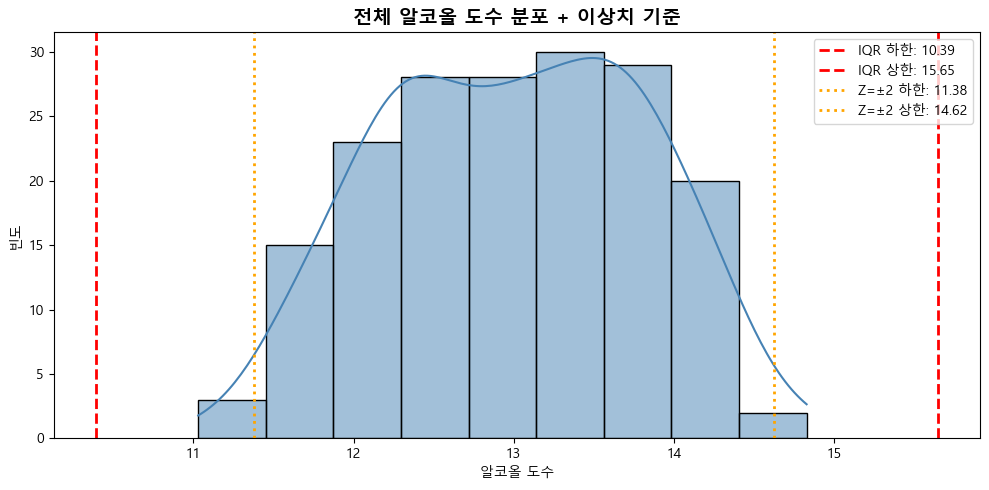

In [ ]:
# 전체 알코올 도수 분포 + 이상치 기준선
fig, ax = plt.subplots(figsize=(10, 5))

data = wine_df['alcohol']

# 히스토그램
sns.histplot(data=wine_df, x='alcohol', kde=True, color='steelblue', ax=ax)

# IQR 이상치 기준
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
iqr_lower = Q1 - 1.5 * IQR
iqr_upper = Q3 + 1.5 * IQR

# Z-score 이상치 기준 (|Z| > 2)
z_lower = data.mean() - 2 * data.std()
z_upper = data.mean() + 2 * data.std()

# 기준선 표시
ax.axvline(iqr_lower, color='red', linestyle='--', linewidth=2, label=f'IQR 하한: {iqr_lower:.2f}')
ax.axvline(iqr_upper, color='red', linestyle='--', linewidth=2, label=f'IQR 상한: {iqr_upper:.2f}')
ax.axvline(z_lower, color='orange', linestyle=':', linewidth=2, label=f'Z=±2 하한: {z_lower:.2f}')
ax.axvline(z_upper, color='orange', linestyle=':', linewidth=2, label=f'Z=±2 상한: {z_upper:.2f}')

ax.set_title('전체 알코올 도수 분포 + 이상치 기준', fontsize=14, fontweight='bold')
ax.set_xlabel('알코올 도수')
ax.set_ylabel('빈도')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

---
### 참고: 왜 표본분산은 N이 아니라 N-1로 나눌까? (베셀 보정)

표본평균을 쓰면 분산이 작아지는 경향이 있어서, 그 과소추정을 보정하려고 n 대신 n-1로 나눈다.

표본분산은 평균을 모르는 상태에서 표본평균 대신 쓰기에, 편차가 **조금 덜 크게**나오는 경향이 있다. (과소추정)\
이를 보정해, **평균적으로 모분산에 맞게** 만들기위해 분모를 1 줄여 n-1로 나눈다.\
표본이 작을수록(n이 작을수록)n과 n-1의 차이가 커 중요하나, n이 작으면 차이가 거의 없다.

이때 1을 뺴는 이유는:  편차들의 합은 항상 0이라서, n개의 편차 중 n-1개만 자유롭게 정할 수 있다.

### 한 줄 결론:
표본평균을 쓰면 분산이 작게 나오는 경향이 있어 그것을 보정하려고 n 대신 n-1로 나눈다
- 모집단 전체를 다 아는 상황(진짜 전체 데이터) → n (ddof=0)
- 표본으로 모집단을 추정하는 상황(대부분 현실) → n-1 (ddof=1, 기본값)
---

#### 알아도 좋고 몰라도 좋은 쉽게 설명하는 계산법

데이터가 3개라 가정해보자.\
x1,x2,x3

이때 표본평균 Xˉ를 기준으로 편차를 구하면 다음이 성립된다.\
(x1 - Xˉ) + (x2- Xˉ) + (x3 - Xˉ) = 0

만약 (x1 - Xˉ), (x2- Xˉ) 를 정하면\
마지막 (x3 - Xˉ)는 자동으로 결정돼야 합이 0이 됨\
이때 진짜 자유롭게 움직일 수 있는 값은 2개 뿐, 이 때문에 정보를 하나 줄여 n-1\
즉, 편차 3개를 마음대로 못 정하기 때문에 일부로 값을 하나 줄이는 것이다.\

언제 중요하나?\
표본이 작을수록(n이 작을수록) n과 n-1 차이가 커서 중요하다.\
만약 표본이 크면 거의 차이 없다

예시로 보기: 반 전체 점수의 퍼짐(분산)을 추정\
어떤 반(모집단)에 학생이 4명 있고, 점수가 이렇게 생겼다 가정해보지.
- 모집단 점수(진짜 전체): 50, 60, 90, 100
- 이 반의 진짜 평균(모평균): μ=75

1) 진짜 분산값은?: 모분산\
σ^2 = (50−75)^2+(60−75)^2+(90−75)^2+(100−75)^2​ / 4 = 425

<br>

2) 만약 4명을 전부 보지 못하고 3명만 본다면? (표본을 본다 생각하기)\
표본 점수: 60, 90, 100
- 표본평균
    - Xˉ = 60 + 90 + 100 / 3 = 83.33....
- 제곱편차합
    - ∑(Xi​−Xˉ)^2 = (60−83.33)^2+(90−83.33)^2+(100−83.33)^2 = 866.67

<br>

3) n으로 나눌 경우: 866.67 / 3 = 288.89
    - 모분산 > 표준분산(n으로 나눔)

4) n-1로 나눌 경우: 866.67 / 3-1 = ​ 433.33
    - 모분산과 표준 분산이 가까움


요약
- 표본평균을 이미 **데이터로 한 번 맞춰서**써버렸기 때문에
- 분산을 구할 땐 그만큼 정보 1개가 줄었다고 보고 n-1로 나눈다.

## Part 5.1: 변동계수 (CV) - 상대적 산포

### 변동계수(Coefficient of Variation, CV)란?
CV는 표준편차를 평균으로 나눈 값으로, 평균 대비 퍼짐을 %로 비교한다. 
때문에 **단위가 달라도, 평균 크기가 달라도 비교가 가능**해진다.
```
표준편차 ÷ 평균
std / mean * 100%
평균에 비해 표준편차가 몇 %인가?
```

- 필요가정
    - 평균이 0에 가깝거나 0이면 CV가 폭주하므로 해석이 부적절하다.
    - 평균이 음수일 수 있는 변수(기준에 따라)도 CV 해석이 애매해질 수 있어 맥락 확인이 필요하다.

#### 어떨때 사용할까?
1. 단위가 다른 변수(kg vs cm 등)의 산포를 비교할 때
2. 평균 스케일이 다른 집단/변수의 상대적 흔들림을 비교할 때
    - 대기업: 평균이 엄청 큼
    - 스타트업: 평균이 작음
    - 표준편차가 대기업이 더 크게 나와도, 평균에 비해 흔들리는 비율은 스타트업이 더 클 수 있다.

#### 이 문제들을 CV로 해결하기
CV는 평균으로 나눠서 단위를 없애고(무단위), "평균 대비 흔들림"을 비율로 비교하게 해준다.\
해석하는 법: CV가 클수록 "**평균 대비 변동이 크다(상대적으로 불안정/들쭉날쭉)**"라고 말한다.

예시 1) 단위가 다른 변수 비교(키 vs 몸무게)<br>
| 변수  |    평균 | 표준편차 |                    CV |
| --- | ----: | ---: | --------------------: |
| 키   | 170cm | 10cm | (10/170 ≈ 5.9%) |
| 몸무게 |  70kg |  8kg |  (8/70 ≈ 11.4%) |

결론: 몸무게가 평균에 비해 더 들쑥날쑥하다.

<br>

예시 2) 스케일이 다른 그룹 비교(대기업 vs 스타트업)
| 그룹   | 평균 매출 |   표준편차 |          CV |
| ---- | ----: | -----: | ----------: |
| 대기업  |   1조원 | 1000억원 | (0.1 = 10%) |
| 스타트업 |  10억원 |    5억원 | (0.5 = 50%) |

표준편차(절대 흔들림)는 대기업이 더 크다.<br>
하지만 평균 대비로 보면 스타트업이 훨씬 더 불안정(변동이 큼) 하다.

In [ ]:
print("\n" + "="*60)
print("Part 5.1: 변동계수 (CV) - 상대적 산포")
print("="*60)

# (1) 변동계수 계산 함수
def cv(data):
    """변동계수(%) 계산"""
    return (data.std() / data.mean()) * 100

# (2) 문제 1: 단위가 다른 변수 비교 - Iris 데이터 활용
print("\n[1. 단위가 다른 변수 비교]")
print("Iris 데이터: 꽃잎 길이(cm) vs 꽃잎 너비(cm)")
print("(단위는 같지만 스케일이 다른 경우)")

petal_length = iris_df['petal length (cm)']
petal_width = iris_df['petal width (cm)']

compared_df = pd.DataFrame({
    '변수': ['꽃잎 길이', '꽃잎 너비'],
    '평균': [petal_length.mean(), petal_width.mean()],
    '표준편차': [petal_length.std(), petal_width.std()],
    'CV(%)': [cv(petal_length), cv(petal_width)],
})
display(compared_df)
# (3) 문제 2: 스케일이 다른 그룹 비교 - Wine 데이터 활용
print("\n" + "-"*60)
print("[2. 스케일이 다른 변수 비교]")
print("Wine 데이터: alcohol vs malic_acid vs magnesium")

alcohol = wine_df['alcohol']
malic_acid = wine_df['malic_acid']
magnesium = wine_df['magnesium']

compared_df = pd.DataFrame({
    '변수': ['alcohol', 'malic_acid', 'magnesium'],
    '평균': [alcohol.mean(), malic_acid.mean(), magnesium.mean()],
    '표준편차': [alcohol.std(), malic_acid.std(), magnesium.std()],
    'CV(%)': [cv(alcohol), cv(malic_acid), cv(magnesium)],
})
display(compared_df)


Part 5.1: 변동계수 (CV) - 상대적 산포

[1. 단위가 다른 변수 비교]
Iris 데이터: 꽃잎 길이(cm) vs 꽃잎 너비(cm)
(단위는 같지만 스케일이 다른 경우)


,변수,평균,표준편차,CV(%)
0,꽃잎 길이,3.758000,1.765298,46.974407
1,꽃잎 너비,1.199333,0.762238,63.555114



------------------------------------------------------------
[2. 스케일이 다른 변수 비교]
Wine 데이터: alcohol vs malic_acid vs magnesium


,변수,평균,표준편차,CV(%)
0,alcohol,13.000618,0.811827,6.244523
1,malic_acid,2.336348,1.117146,47.815905
2,magnesium,99.741573,14.282484,14.319489


---

## Part 6: 기술통계 - 데이터 분포 탐색

### "데이터의 생김새를 눈으로 확인하기" → 4가지 그래프

같은 데이터를 다양한 그래프로 그려보면 서로 다른 정보를 얻을 수 있습니다.

- **박스플롯**: 중앙값, IQR, 이상치를 한눈에

- **히스토그램**: 구간별 빈도 (막대 높이 = 해당 구간에 몇 개?)

- **밀도그림 (KDE)**: 히스토그램을 부드러운 곡선으로 만든 것

- **바이올린 도표**: 박스플롯 + 밀도그림을 합친 것


Part 6: 기술통계 - 데이터 분포 탐색


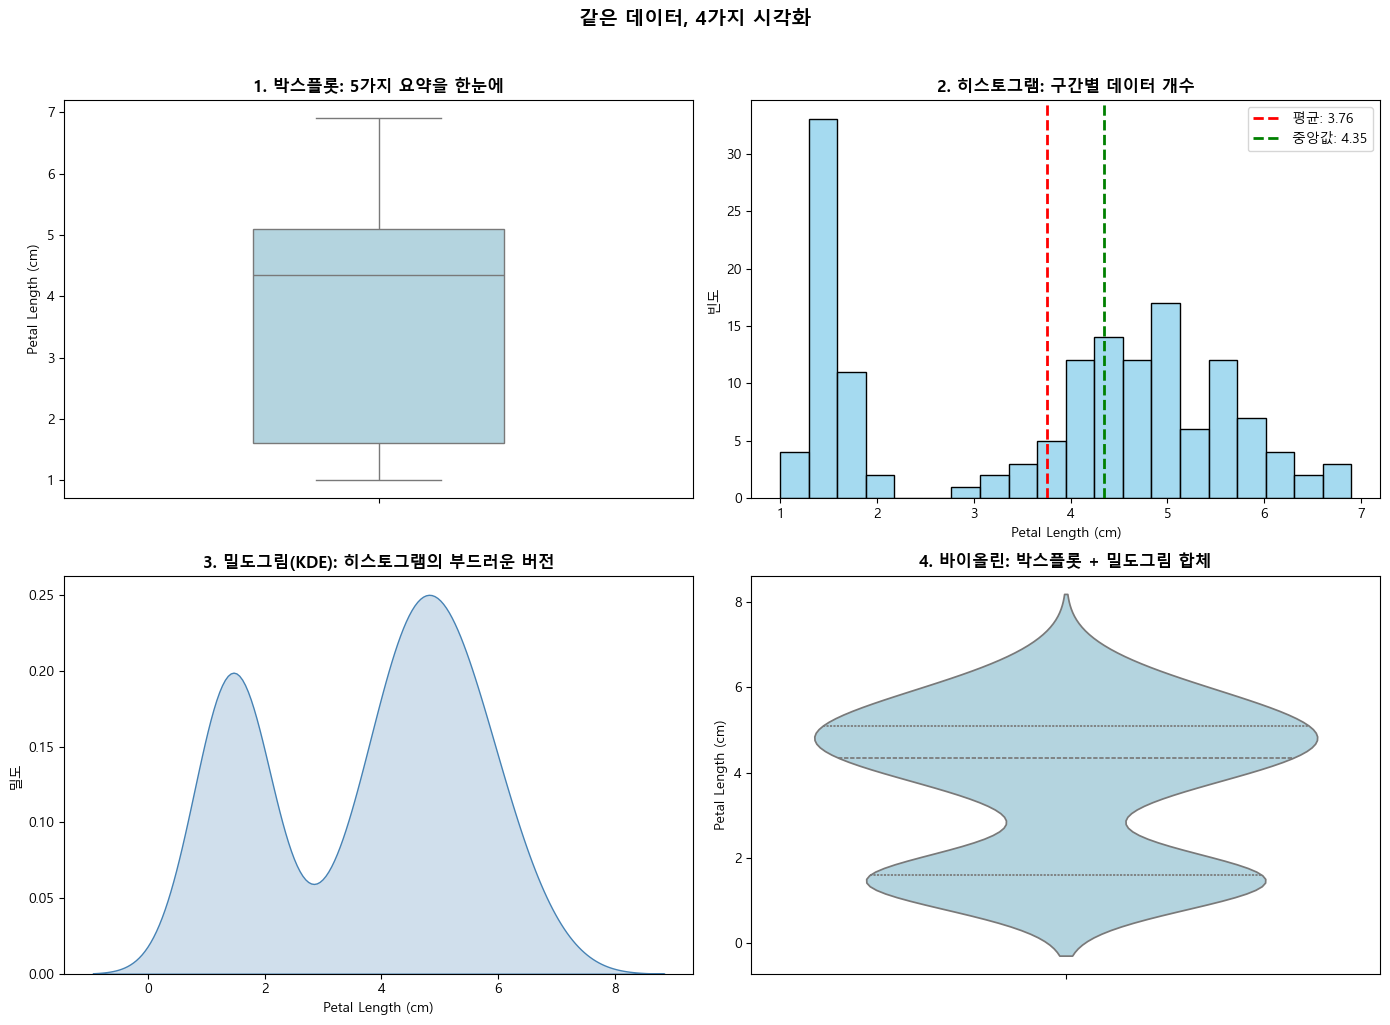

In [ ]:
print("\n" + "="*60)
print("Part 6: 기술통계 - 데이터 분포 탐색")
print("="*60)

# Iris 꽃잎 길이를 4가지 그래프로 그리기
data = iris_df['petal length (cm)']

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# (1) 박스플롯
sns.boxplot(y=data, ax=ax[0, 0], color='lightblue', width=0.4)
ax[0, 0].set_ylabel('Petal Length (cm)')
ax[0, 0].set_title('1. 박스플롯: 5가지 요약을 한눈에', fontweight='bold')

# (2) 히스토그램
sns.histplot(data, bins=20, kde=False, color='skyblue', edgecolor='black', ax=ax[0, 1])
ax[0, 1].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'평균: {data.mean():.2f}')
ax[0, 1].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'중앙값: {data.median():.2f}')
ax[0, 1].set_xlabel('Petal Length (cm)')
ax[0, 1].set_ylabel('빈도')
ax[0, 1].set_title('2. 히스토그램: 구간별 데이터 개수', fontweight='bold')
ax[0, 1].legend()

# (3) 밀도그림 (KDE)
sns.kdeplot(data, fill=True, color='steelblue', ax=ax[1, 0])
ax[1, 0].set_xlabel('Petal Length (cm)')
ax[1, 0].set_ylabel('밀도')
ax[1, 0].set_title('3. 밀도그림(KDE): 히스토그램의 부드러운 버전', fontweight='bold')

# (4) 바이올린 도표
sns.violinplot(y=data, ax=ax[1, 1], color='lightblue', inner='quartile')
ax[1, 1].set_ylabel('Petal Length (cm)')
ax[1, 1].set_title('4. 바이올린: 박스플롯 + 밀도그림 합체', fontweight='bold')

plt.suptitle('같은 데이터, 4가지 시각화', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


----------------------------------------
종별 분포 비교: 붓꽃 3종의 꽃잎 길이가 얼마나 다를까?
----------------------------------------


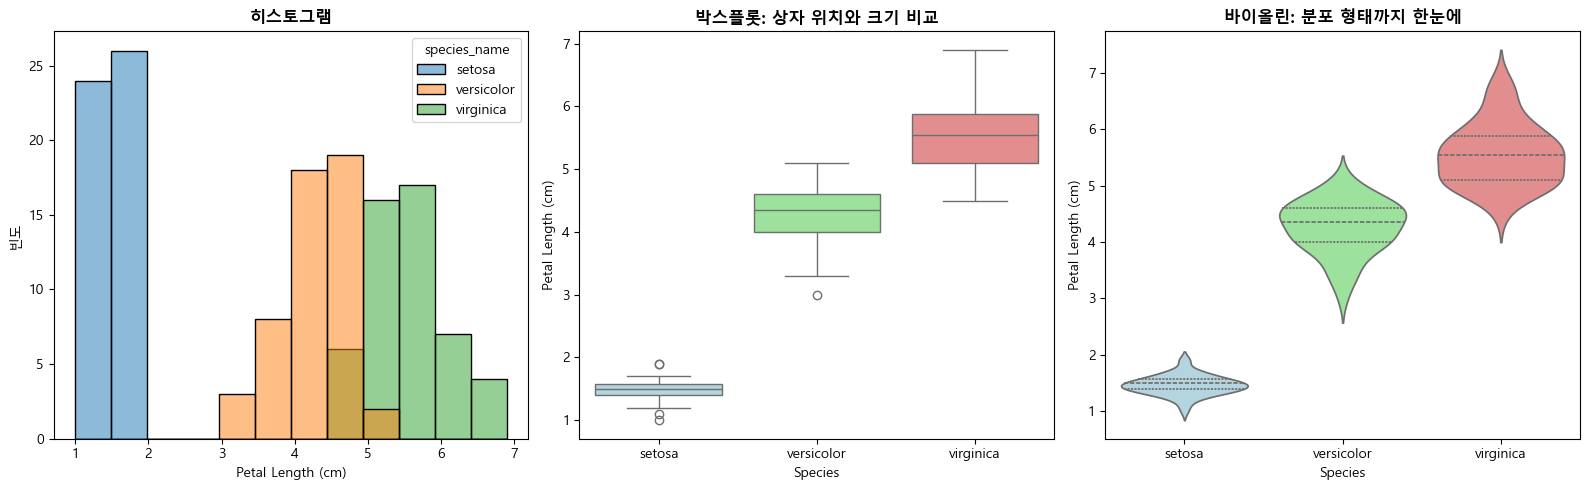

In [ ]:
# 종별 분포 비교 - 그룹 간 차이를 한눈에!
print("\n" + "-"*40)
print("종별 분포 비교: 붓꽃 3종의 꽃잎 길이가 얼마나 다를까?")
print("-"*40)

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# (1) 종별 히스토그램
sns.histplot(data=iris_df, x='petal length (cm)', hue='species_name', 
            bins=12, alpha=0.5, edgecolor='black', ax=ax[0])
ax[0].set_xlabel('Petal Length (cm)')
ax[0].set_ylabel('빈도')
ax[0].set_title('히스토그램', fontweight='bold')

# (2) 종별 박스플롯
sns.boxplot(data=iris_df, x='species_name', y='petal length (cm)',
            palette=['lightblue', 'lightgreen', 'lightcoral'], ax=ax[1])
ax[1].set_xlabel('Species')
ax[1].set_ylabel('Petal Length (cm)')
ax[1].set_title('박스플롯: 상자 위치와 크기 비교', fontweight='bold')

# (3) 종별 바이올린
sns.violinplot(data=iris_df, x='species_name', y='petal length (cm)',
            palette=['lightblue', 'lightgreen', 'lightcoral'], inner='quartile', ax=ax[2])
ax[2].set_xlabel('Species')
ax[2].set_ylabel('Petal Length (cm)')
ax[2].set_title('바이올린: 분포 형태까지 한눈에', fontweight='bold')

plt.tight_layout()
plt.show()

#### 히스토그램 bins 설정 가이드

| 방법 | 공식/설명 | 특징 |
|------|----------|------|
| **auto** | Sturges와 FD 중 bin이 더 많은 쪽 선택 | 무난한 기본값 |
| **sturges** | $k = 1 + \log_2(n)$ | 단순, 작은 데이터에 적합 |
| **fd** | $h = 2 \cdot IQR \cdot n^{-1/3}$ | IQR 기반, 이상치에 강건 |
| **숫자 직접 지정** | bins=10, 20 등 | 원하는 세밀도로 조절 |
| **도메인 기반** | np.arange(0, 100, 10) | 해석 용이 (예: 나이 10세 단위) |

> 기본값(auto)으로 충분. 봉우리가 안 보이면 bins↑, 울퉁불퉁하면 bins↓

#### KDE bandwidth 설정 가이드

| 방법 | 설명 | 특징 |
|------|------|------|
| **bw_adjust=1.0** | Scott/Silverman 자동 계산값 × 1.0 | 기본값 |
| **bw_adjust=0.5** | 기본값의 0.5배 | 더 뾰족 (세밀) |
| **bw_adjust=2.0** | 기본값의 2배 | 더 부드러움 |

> 기본값(1.0)으로 충분. 봉우리가 안 보이면 bw_adjust↓, 울퉁불퉁하면 bw_adjust↑

---

## Part 7: 왜도(Skewness)와 첨도(Kurtosis)
평균/표준편차를 대표값으로 써도 되는가

이상치/꼬리 때문에 중앙값/IQR/변환(로그 등)이 필요한가

### 0) 왜도(Skewness)와 첨도(Kurtosis)를 보는 이유
1) 평균/표준편차를 대표값으로 써도 되는가?
2) 이상치/꼬리 때문에 중앙값/IQR/변환(로그 등)이 필요한가?

### 1) 왜도(Skewness)란?: "한쪽으로 치우쳤나?"
왜도는 꼬리(tail)가 어디가 더 길게 늘어졌는지를 보는 값이다. <br>
한쪽 꼬리가 더 길면 왜도는 0에서 멀어진다(부호는 꼬리 방향).

언제쓰나?\
평균이 꼬리에 끌려갈 가능성이 있는지 파악하기 위해\
이상치가 어느쪽(왼쪽, 오른쪽)에 생길지 방향을 볼때

<img src="images/pr_01/왜도.png" width="100%">

| 구분     | 의미          | 평균-중앙값 관계(경향) | 취해야할 액션                        |
| ------ | ----------- | ------------- | ---------------------------- |
| 왜도 > 0 | 오른쪽(큰 값) 꼬리 김  | 평균 > 중앙값      | 중앙값/IQR 같이 보기, 로그 변환 후보      |
| 왜도 < 0 | 왼쪽(작은 값) 꼬리 김 | 평균 < 중앙값      | 중앙값/IQR 같이 보기, 왼쪽 꼬리 원인 점검   |
| 왜도 ≈ 0 | 대칭에 가까움     | 평균 ≈ 중앙값      | 평균/표준편차 사용 가능성 높음(그래도 그림 확인) |

- 양의 왜도면 평균이 중앙값보다 커지는 경향이 있다(큰 값 몇 개가 평균을 끌어올림).
- 음의 왜도면 평균이 중앙값보다 작아지는 경향이 있다.

#### 왜도를 어떻게 읽어야 하나?
1단계: 부호만 본다 (방향)\
왜도 > 0 : 오른쪽(큰 값) 꼬리 김\
왜도 < 0 : 왼쪽(작은 값) 꼬리 김

2단계: 크기를 본다 (얼마나 심한지)\
(절대값 기준)\
∣skew∣<0.5 : 거의 대칭에 가까움\
0.5≤∣skew∣<1 : 좀 비대칭(중간 정도)\
∣skew∣≥1 : 비대칭이 큼(강함)\

3단계: 그림 + 평균/중앙값으로 확인한다\
왜도 숫자 하나만 보면 오해할 수 있기 떄문에 히스토그램/KDE/박스플롯을 같이 보고\
평균과 중앙값 관계(평균이 꼬리 방향으로 끌림)를 같이 체크하면 해석이 안정적이다.

### 2) 첨도(Kurtosis)란?: "극단적인 일이 얼마나 자주 나오나?"
첨도는 **꼬리의 두께(= 극단값이 얼마나 자주 나오나)** 느낌에 가깝고, 극단값이 얼마나 자주 나올지 신호를 준다.

여기서 말하는 첨도는 보통 초과첨도(excess kurtosis) 기준이다.\
초과첨도 = 0이면 정규분포 수준의 꼬리 두께다.

언제쓰나?\
극단값이 **가끔이 아니라 생각보다 자주** 나오는 데이터인지 감을 잡을 때\
평균/표준편차 기반 요약이 위험할 가능성을 볼 때


<img src="images/pr_01/첨도.png" width="30%">

| 초과첨도 값 | 꼬리 두께(느낌) | 의미        | 실무 액션                  |
| -----: | --------- | --------- | ---------------------- |
|    ≈ 0 | 정규 수준     | 극단값 빈도 보통 | 표준편차 사용 가능성 높음(그림 확인)  |
|    > 0 | 두꺼움       | 꼬리가 두꺼운 편이라 극단값이 더 자주 나올 수 있다. | IQR/로버스트 요약, 이상치 점검 강화 |
|    < 0 | 얇음        | 꼬리가 얇은 편이라 극단값이 덜 나올 수 있다.  | 일반 요약 통계로도 무난할 수 있음    |



### 3) 꼬리 리스크(Tail Risk): 첨도가 왜 위험을 말해주나?
첨도가 높으면, 평소에는 별일 없는데 큰 사건이 ‘예상보다 자주’ 터진다.

그래서 금융에서 첨도를 무시하면 이런 일이 생긴다:<br>
-"정규분포면 이런 폭락은 거의 안 나오겠지"라고 계산함<br>
-근데 실제 데이터는 꼬리가 두꺼워서(첨도↑) 폭락이 더 자주 발생<br>
-결과: 리스크(손실 가능성)를 과소평가


보통 ±1%인데 가끔 ±10%가 생각보다 자주 나오는 시장은<br>
초과첨도 > 0일 가능성이 크다.<br>

In [ ]:
# Iris 꽃잎 길이 사용
data = iris_df['petal length (cm)']

# (1) 왜도와 첨도 계산
print(f"왜도: {data.skew():.2f}") #음수 ---> 해석 --> 왼쪽으로 꼬리 긴 분포
print(f"첨도: {data.kurt():.2f}") #음수 ---> 해석 --> 정규 분포보다 꼬리가 얇다 (극단값이 있을 확률이 적음)


# (2) 종별 왜도와 첨도 비교
species_df = (
    iris_df
    .groupby('species_name')['petal length (cm)']
    .agg({
        ('평균', 'mean'),
        ('중앙값', 'median'),
        ('왜도', 'skew'),
        ('첨도', 'kurt'),
    }))

display(species_df)

#Set : 집합 (중복을 허용하지 않은 자료구조)

왜도: -0.27
첨도: -1.40


,왜도,첨도,중앙값,평균
species_name,,,,
setosa,0.106394,1.021576,1.50,1.462
versicolor,-0.606508,0.047903,4.35,4.260
virginica,0.549445,-0.153779,5.55,5.552


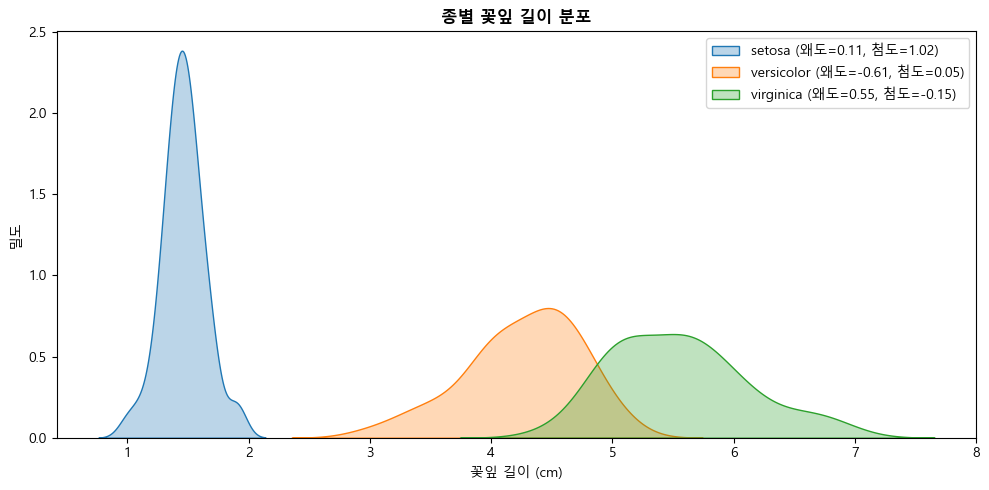

In [ ]:
# (3) 시각화: 종별 KDE 비교
fig, ax = plt.subplots(figsize=(10, 5))

for species in iris_df['species_name'].unique():
    subset = iris_df[iris_df['species_name'] == species]['petal length (cm)']
    sns.kdeplot(subset, label=f"{species} (왜도={subset.skew():.2f}, 첨도={subset.kurt():.2f})", ax=ax, fill=True, alpha=0.3)

ax.set_title('종별 꽃잎 길이 분포', fontweight='bold')
ax.set_xlabel('꽃잎 길이 (cm)')
ax.set_ylabel('밀도')
ax.legend()

plt.tight_layout()
plt.show()

왜도 해석
- 왜도 > 0 : 오른쪽(큰 값) 꼬리 김
- 왜도 < 0 : 왼쪽(작은 값) 꼬리 김

setosa (0.11)\
거의 0 → 거의 대칭\
평균/중앙값이 비슷하게 나올 가능성이 큼\
그래프도 한 가운데가 봉우리이고 꼬리도 크게 한쪽으로 안 쏠려 있음\

versicolor (-0.61)\
음의 왜도 → 왼쪽(작은 값) 꼬리가 더 김\
의미: 값이 대체로 4~5 근처에 많지만, 상대적으로 작은 값(3 근처) 쪽으로 더 늘어진다\
평균은 중앙값보다 작아지는 쪽으로 끌릴 가능성이 큼

virginica (0.55)\
양의 왜도 → 오른쪽(큰 값) 꼬리가 더 김\
의미: 값이 대체로 5~6 근처에 많지만, 상대적으로 큰 값(6~7대) 쪽으로 더 늘어진다\
평균은 중앙값보다 커지는 쪽으로 끌릴 가능성이 큼

첨도 해석
- 초과첨도 = 0 → 정규분포 수준
- 초과첨도 > 0 → 꼬리가 두꺼움(극단값이 상대적으로 더 자주)
- 초과첨도 < 0 → 꼬리가 얇음(극단값이 상대적으로 덜함)

setosa (왜도=0.11, 첨도=1.02)
- 초과첨도 1.02 → 정규보다 ‘가운데가 더 뾰족하고’, 꼬리 쪽(극단)이 상대적으로 더 나오는 편

versicolor (왜도=-0.61, 첨도=0.05)
- 초과첨도 0.05는 거의 0 → 정규분포와 꼬리 두께가 비슷한 편

virginica (왜도=0.55, 첨도=-0.15)
- 초과첨도 -0.15 → 정규보다 꼬리가 아주 살짝 얇거나, 가운데가 덜 뾰족(좀 더 완만)한 편